# Notebook for brain-bridge project

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn import datasets, plotting 
import ipyniivue
import templateflow.api as tf
import ipywidgets as widgets
import plotly.graph_objects as go
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
# ! pip install ipyniivue
# ! pip install templateflow

struct_df = pd.read_csv('data/all_structural_metrics_HCP.csv')
struct_df

/Users/mkersey/Library/Python/3.9/lib/python/site-packages/bids/layout/validation.py:46: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "


,id_number,lh_G_and_S_frontomargin_NumVert,lh_G_and_S_occipital_inf_NumVert,lh_G_and_S_paracentral_NumVert,lh_G_and_S_subcentral_NumVert,lh_G_and_S_transv_frontopol_NumVert,lh_G_and_S_cingul-Ant_NumVert,lh_G_and_S_cingul-Mid-Ant_NumVert,lh_G_and_S_cingul-Mid-Post_NumVert,lh_G_cingul-Post-dorsal_NumVert,...,rh_S_parieto_occipital_CurvInd,rh_S_pericallosal_CurvInd,rh_S_postcentral_CurvInd,rh_S_precentral-inf-part_CurvInd,rh_S_precentral-sup-part_CurvInd,rh_S_suborbital_CurvInd,rh_S_subparietal_CurvInd,rh_S_temporal_inf_CurvInd,rh_S_temporal_sup_CurvInd,rh_S_temporal_transverse_CurvInd
0,857263,854,1198,1747,1327,773,2589,1666,1604,639,...,5.1,5.2,4.7,2.6,3.7,0.3,4.1,1.8,10.1,0.4
1,133928,1123,1723,1771,1036,676,2674,1476,1605,681,...,4.8,5.2,4.8,7.2,2.8,1.0,3.3,2.5,8.7,0.7
2,101006,1038,1621,1252,1073,496,1697,1296,1006,442,...,3.5,8.0,2.5,1.1,1.3,0.4,2.1,1.7,7.9,0.5
3,788876,884,1250,1275,1023,394,2217,1101,1090,637,...,3.9,3.7,2.7,1.4,2.7,0.3,2.3,1.7,6.8,0.4
4,731140,1189,1423,1810,1462,486,2310,1257,1457,610,...,4.5,16.4,3.2,2.1,1.5,0.6,3.5,1.2,8.3,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,197550,1061,1362,1771,1216,612,2025,1178,1131,503,...,3.4,3.0,4.1,1.3,1.8,0.3,1.8,1.1,7.4,0.6
1038,106016,1358,1770,1663,1475,872,2207,1607,1496,469,...,4.3,5.7,2.4,2.4,1.8,0.7,2.6,2.5,11.2,0.4
1039,590047,1412,1590,1684,1787,736,3019,1669,1506,527,...,6.2,10.6,5.0,3.2,3.6,1.4,6.0,3.0,10.5,0.8
1040,179245,1214,1768,1670,1171,802,2026,1190,1177,508,...,3.8,3.8,2.7,1.7,2.9,0.8,2.6,1.6,6.0,0.3


In [2]:
# Create individual dataframes for each measure
thick_df = struct_df.filter(regex=('ThickAvg$'))
thick_df.insert(0, 'id_number', struct_df['id_number'])
vol_df = struct_df.filter(regex='GrayVol$')
vol_df.insert(0, 'id_number', struct_df['id_number'])
area_df = struct_df.filter(regex='SurfArea$')
area_df.insert(0, 'id_number', struct_df['id_number'])

#thick_df.head()
#print(thick_df[thick_df['id_number'] == 857263].values[0].__class__)
# add a zero onto the beginnign of a numpy array
#np.insert(thick_df[thick_df['id_number'] == 857263].values[0], 0, 0)
#print(thick_df.index.values[0].__class__)

In [3]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
#print(destrieux_atlas['labels'])
# print(len(destrieux_atlas['labels']))
# print(destrieux_atlas['labels'][0].__class__)

test = vol_df.filter(regex='^lh')
test.columns = test.columns.str.replace('lh_', '')


# split at the last underscore, and take the first part
#test.columns = test.columns.str.rsplit('_', 1).str[0]
# print(test.columns.values)
# print(len(test.columns.values))

list = [i.decode('UTF-8') for i in destrieux_atlas['labels']]
# print(list)

# what is in the atlas that is not in the dataframe?
# decode the labels into strings using .decode('UTF-8')
#print(set(list) - set(test.columns.values))
#print(set(destrieux_atlas['labels']) - set(test.columns.values))
#loc = test.columns.get_loc('Lat_Fis-post_GrayVol')
#print(loc)
loc = test.columns.get_loc('Lat_Fis-post_GrayVol')
#print(loc)

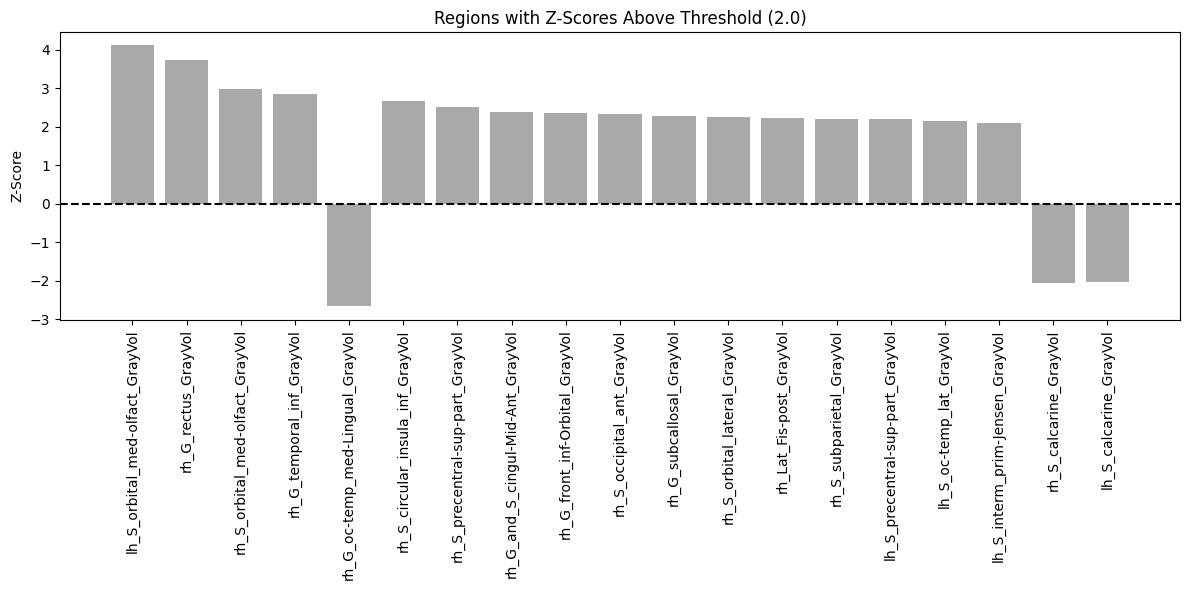

In [4]:
out_brain = widgets.Output()
out_table = widgets.Output()
out_plot = widgets.Output()

def zscore(id_number, dtype):
    if dtype == 'Volume':
        df = vol_df
    elif dtype == 'Area':
        df = area_df
    elif dtype == 'Thickness':
        df = thick_df
    patient_df = df[df['id_number'] == id_number].drop(columns=['id_number'])
    control_df = df[df['id_number'] != id_number].drop(columns=['id_number'])
    control_means = np.mean(control_df, axis=0)
    control_stds = np.std(control_df, axis=0)
    return (patient_df - control_means) / control_stds

def plot_brain(z_data, dtype):
    # The left and right hemisphere views will be stored here
    left_hemi_widget = None
    right_hemi_widget = None

    # 1. Determine the global min and max values across both hemispheres for consistent color scaling
    global_vmin = min(z_data.min())
    global_vmax = max(z_data.max())

    for hemi in ['left', 'right']:
        z_data_tmp = z_data.copy()

        # Fetching Destrieux atlas and fsaverage
        destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
        fsaverage = datasets.fetch_surf_fsaverage()

        # Filter z_data to only include variables starting with lh_ or rh_
        if hemi == 'left':
            z_data_tmp = z_data_tmp.filter(regex='^lh_')
            z_data_tmp.columns = z_data_tmp.columns.str.replace('lh_', '')
        else:
            z_data_tmp = z_data_tmp.filter(regex='^rh_')
            z_data_tmp.columns = z_data_tmp.columns.str.replace('rh_', '')

        # remove the ending of columns after last underscore
        z_data_tmp.columns = z_data_tmp.columns.str.rsplit(pat='_', n=1).str[0]
        
        if 'Lat_Fis-post' not in z_data_tmp.columns:
            # Handle the case when 'Lat_Fis-post' doesn't exist. Raise an error.
            raise ValueError('Lat_Fis-post does not exist. I must place a Medial_wall column in the dataframe after this column to match up with the atlas labels.')

        loc = z_data_tmp.columns.get_loc('Lat_Fis-post')
        z_data_tmp.insert(loc+1, 'Medial_wall', 0)
        z_data_tmp.insert(0, 'Unknown', 0)

        # Zip the values of z_data to the labels of the Destrieux atlas
        region_values = dict(zip(destrieux_atlas['labels'], z_data_tmp.values[0]))

        # Initialize an array with zeros
        mapped_values = np.zeros_like(destrieux_atlas[f'map_{hemi}'], dtype=float)

        # Populate the mapped_values array using regi)on_values dictionary
        for label, value in region_values.items():
            region_idx = destrieux_atlas['labels'].index(label)
            mapped_values[destrieux_atlas[f'map_{hemi}'] == region_idx] = value

        fsavg = fsaverage.infl_left if hemi == 'left' else fsaverage.infl_right

        # Plotting
        
        # For right hemisphere, set the view to "Right"
        hemi_view = "right" if hemi == "right" else "left"

        view = plotting.view_surf(fsavg, mapped_values,
                                cmap='coolwarm', symmetric_cmap=True,
                                vmax=np.max([np.abs(global_vmin), np.abs(global_vmax)]))
                                #view=hemi_view)

        widget = widgets.HTML(view.get_iframe())#.decode())

        if hemi == 'left':
            left_hemi_widget = widget
        else:
            right_hemi_widget = widget

        # Display the widgets side by side  
    with out_brain:
        display(widgets.HBox([left_hemi_widget, right_hemi_widget]))

def plot_bar_for_thresholded_regions(z_data, dtype, thresh):

    prominent_regions = [col for col in z_data.columns if z_data[col].abs().mean() > thresh]
    # Sort in descending order
    prominent_regions.sort(key=lambda x: z_data[x].abs().mean(), reverse=True)
    
    # set color to be red if z-score is positive, blue if negative
    # color_map = lambda z: 'red' if z > 0 else 'blue'
    plt.figure(figsize=(12, 6))
    plt.bar(prominent_regions, z_data[prominent_regions].values[0], color='darkgrey')
    plt.ylabel('Z-Score')
    plt.title(f'Regions with Z-Scores Above Threshold ({thresh})')
    plt.xticks(rotation=90)
    # add a horizontal line at z=0
    plt.axhline(y=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

def create_plot(id_number, dtype, region):
    if dtype == 'Volume':
        df = vol_df
    elif dtype == 'Area':
        df = area_df
    elif dtype == 'Thickness':
        df = thick_df

    region_data = df[region]
    
    subject_data = df[df['id_number'] == id_number][region].values[0]
    
    # initialize subplots but make the right plot wider than the left
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})

    # Scatter plot with jitter
    sns.boxplot(y=region_data, ax=ax[0], color='lightgray', showfliers=False)
    sns.stripplot(y=region_data, jitter=0.3, size=3, ax=ax[0], alpha=0.6)
    ax[0].scatter(x=0, y=subject_data, color='red', s=50, label=f'Subject {id_number}: Val={subject_data:.2f}')
    ax[0].set_title(f'Distribution of {region}')
    ax[0].set_ylabel(dtype)
    ax[0].set_xticks([])  # Hide x-axis ticks as they are not necessary in this context.
    ax[0].set_xlabel('Subjects')
    ax[0].legend()

    # Distribution with z-score
    sns.kdeplot(region_data, ax=ax[1], shade=True)
    z_val = (subject_data - region_data.mean()) / region_data.std()
    ax[1].axvline(x=subject_data, color='r', linestyle='--', label=f'Subject {id_number}: Z={z_val:.2f}')
    ax[1].set_title(f'Z-Score Distribution for {region}')
    ax[1].set_xlabel(dtype)
    ax[1].legend()
    
    with out_plot:
        out_plot.clear_output(wait=True)
        plt.tight_layout()
        plt.show()

def create_interactive_table(id_number, z_data, dtype, thresh):
    prominent_regions = [col for col in z_data.columns if z_data[col].abs().mean() > thresh]
    # Sort in descending order
    prominent_regions.sort(key=lambda x: z_data[x].abs().mean(), reverse=True)

    region_selector = widgets.Select(options=prominent_regions, description='Region:')

    def on_region_selected(change):
        region = change['new']
        create_plot(id_number, dtype, region)

    region_selector.observe(on_region_selected, names='value')

    with out_table:
        display(region_selector)
    
    # Trigger an initial plot when the table is first created.
    create_plot(id_number, dtype, prominent_regions[0])

def submit_id(b):
    out_brain.clear_output(wait=True)
    # Fetch the current selected value from the radio buttons inside the function
    dtype = data_type.value

    # get the id number from the input cell
    id_number = id.value.strip()
    # if the id number is not a number, raise an error
    if not id_number.isdigit():
        raise ValueError('Please enter a number for the ID number.')
    
    id_number = np.int64(id_number)
    #print(id_number.__class__)
    #print(id_number)

    z_data = zscore(id_number, dtype)
    plot_brain(z_data, dtype)

def submit_thresh(b):
    out_table.clear_output(wait=True)
    out_plot.clear_output(wait=True)

    # Fetch the current selected value from the radio buttons inside the function
    dtype = data_type.value

    # get the id number from the input cell
    id_number = id.value.strip()
    # if the id number is not a number, raise an error
    if not id_number.isdigit():
        raise ValueError('Please enter a number for the ID number.')
    
    id_number = np.int64(id_number)
    thresh_value = thresh.value
    thresh_value = np.float64(thresh_value)

    z_data = zscore(id_number, dtype)

    plot_bar_for_thresholded_regions(z_data, dtype, thresh_value)
    #interactive_plot_output = create_interactive_table(id_number, z_data, dtype, thresh_value)
    #display(interactive_plot_output)
    create_interactive_table(id_number, z_data, dtype, thresh_value)

# Add an input cell to enter an id_number
id = widgets.Text(
    value='',
    placeholder='Enter ID number',
    description='ID Number:',
    disabled=False  
)

# Add an input cell for the threshold
thresh = widgets.FloatText(
    value=2,
    description='Z-Score Threshold:',
    disabled=False
)

# Add radio buttons to select the data type
data_type = widgets.RadioButtons(
    options=['Volume', 'Area', 'Thickness'],
    description='Structural Metric:',
    disabled=False,
    value='Volume'
)

# create a submit button for the threshold that will update the table and plot
thresh_button = widgets.Button(description="Submit")
thresh_button.on_click(submit_thresh)  # Bind the button click to your function

# Create the submit button
submit_button = widgets.Button(description="Submit")
submit_button.on_click(submit_id)  # Bind the button click to your function


id.layout.width = '300px'
thresh.layout.width = '300x'
# make more space for the text in thresh
id.style.description_width = '70px'
thresh.style.description_width = '120px'

box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='flex-start',
                width='100%')

# group_id = widgets.HBox([id, submit_button], layout=box_layout)
group_thresh = widgets.HBox([thresh, thresh_button], layout=box_layout)

# Display widgets for Z-score brains
display(widgets.VBox([id, data_type, submit_button, out_brain]))

# Display widgets for threshold/plots
display(widgets.VBox([group_thresh, out_table, out_plot]))

# # Display widgets for Z-score brains
# display(id)
# display(data_type)
# display(submit_button)
# display(out_brain)

# #Display widgets for threshold/plots
# display(thresh)
# display(thresh_button)
# display(out_table)
# display(out_plot)

In [ ]:

# import matplotlib.pyplot as plt

# # Given threshold
# threshold = 1.5

# # Filtering regions above threshold
# filtered_regions = {k: v for k, v in region_values.items() if v > threshold}
# # Sort in descending order
# filtered_regions = {k: v for k, v in sorted(filtered_regions.items(), key=lambda item: item[1], reverse=True)}

# # Create a dummy figure just to display a legend
# fig, ax = plt.subplots()
# for label, value in filtered_regions.items():
#     ax.plot([], [], label=f'{label}: {value.round(3)}', color=plt.cm.coolwarm(value))  # Assuming you're using the 'coolwarm' colormap

# ax.axis('off')
# plt.legend(loc='center')
# plt.show()
# display(thresh)


In [ ]:
# # Filtering regions above threshold
# filtered_regions = {k: v for k, v in region_values.items() if v < -threshold}
# # Sort in descending order
# filtered_regions = {k: v for k, v in sorted(filtered_regions.items(), key=lambda item: item[1], reverse=True)}

# # Create a dummy figure just to display a legend
# fig, ax = plt.subplots()
# for label, value in filtered_regions.items():
#     ax.plot([], [], label=f'{label}: {value.round(3)}', color=plt.cm.coolwarm(value))  # Assuming you're using the 'coolwarm' colormap

# ax.axis('off')
# plt.legend(loc='center')
# plt.show()